# Description

This script is for a Fisher-Wright model of evolution that includes fitness. Population information is stored in a network. The whole population is replaced at each t+1. New alleles in t+1 can arise from these in t.

# Functions

In [13]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns

# from collections import Counter
# from itertools import combinations
# import matplotlib.colors as mcolors
# import ete3

from project_package.generate_pop import generate_initial_pop_unlinked
from project_package.simplify import remove_empty_leaves_and_rescale_edges
from project_package.plot import visualize_pop
from project_package.run_model import update_pop
from project_package.run_model import run_until_fixation

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/tmp/ipykernel_1421814/1033467046.py:49: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm,label='fitness')


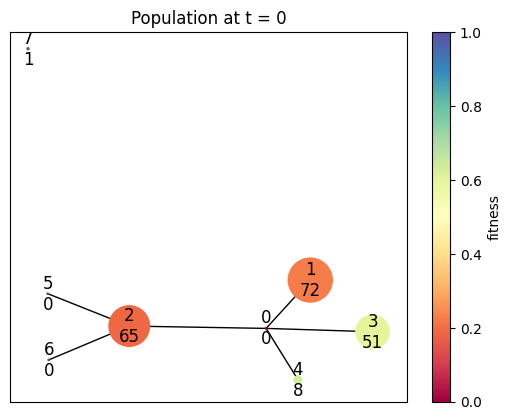

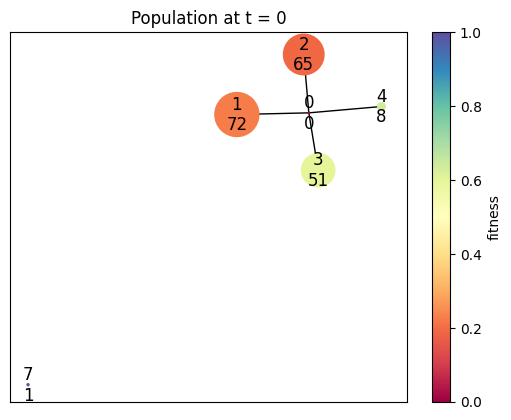

In [59]:
def visualize_pop(G,i='0',hide=False,view_node_labels=True,view_edge_labels=True,abundance_threshold=1):

    H=G.copy()
    # remove nodes with abundance less than x%
    if str(abundance_threshold)[-1]=='%':
        thr=np.round(sum([attr['abundance'] for node_id, attr in H.nodes(data=True)])*int(abundance_threshold[:-1])/100)
    else:
        thr=abundance_threshold
    
    H.update(nodes=[[node_id,{'abundance':0}] for node_id, attr in H.nodes(data=True) if attr['abundance'] < thr])
    
    if hide==True:
        H=remove_empty_leaves_and_rescale_edges(H)
              
    # define node_sizes scaling factor
    def rescale(abundances):
        minsize=10 # [10^1] size of smallest node
        maxsize=10000 # [10^4] size of largest node
        pseudocount=0.01
        abundances=np.array(abundances)+pseudocount
        a=np.log10(abundances)/max(np.log10(abundances))
        b=a*(np.log10(maxsize)-np.log10(minsize))
        return(np.round(np.power(10,b))+np.log10(minsize))
    
    abundances=[attr['abundance'] for node_id, attr in H.nodes(data=True)]
    rescaled_abundances=rescale(abundances)

    # define colors
    cmap = plt.get_cmap('Spectral')
    norm = mcolors.Normalize(vmin=0, vmax=1)
    node_colors = [cmap(norm(H.nodes[node]['fitness'])) for node in H.nodes()]
    
    # draw network
    pos = nx.spring_layout(H)
    nx.draw_networkx_nodes(H, pos, node_color=node_colors, node_size=rescaled_abundances)
    
    nx.draw_networkx_edges(H, pos, edge_color="black")
    
    if view_node_labels==True:
        nx.draw_networkx_labels(H, pos, font_size=12, font_family="sans-serif",
                           labels={node:'\n'.join(map(str,[node,attr['abundance']])) for node,attr 
                                   in H.nodes(data=True) if attr['abundance']>=thr})
    if view_edge_labels==True:        
        nx.draw_networkx_edge_labels(H, pos,edge_labels={(start, end): attr["distance"] for start, end, attr
                                                         in H.edges(data=True)})
        
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=1))
    sm.set_array([])
    cbar = plt.colorbar(sm,label='fitness')
    plt.title("Population at t = "+ str(i))
    
########

n=4 # number of strains
fitnesses=np.insert(np.random.rand(n), 0, 0) # # an array of n random numbers generated between 0 and 1
abundances=np.insert(np.ceil(np.random.rand(n)*100).astype(int),0,0) # an array of n random numbers generated between 1 and 100
G = nx.complete_bipartite_graph(1,n) # create empty graph of n strains
for i in range(len(G.nodes)): # for each strain, add fitness and abundance data
    G.add_node(i, abundance=abundances[i],fitness=fitnesses[i])
for start,end in G.edges:
    G.add_edge(start,end,distance=999)
G.update(edges=[[2,n+1,{'distance':1}],[2,n+2,{'distance':1}]], nodes=[[n+1,{'abundance':0,'fitness':1}],[n+2,{'abundance':0,'fitness':1}],[n+3,{'abundance':1,'fitness':1}]])

visualize_pop(G,view_edge_labels=False,abundance_threshold=0)

plt.figure()
visualize_pop(G,view_edge_labels=False,hide=True,abundance_threshold=0)

/tmp/ipykernel_1421814/1642149511.py:47: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm,label='fitness')


(1:1,((12:4)8:3)2:1,3:1,4:1);

   /-1
  |
  |-2 /8 /-12
-0|
  |--3
  |
   \-4


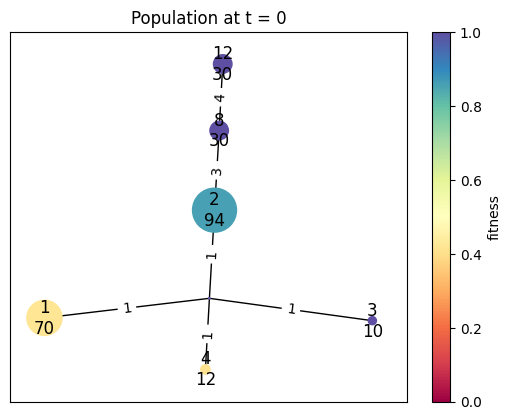

In [38]:
def make_ete_tree(G):
    root = min(G.nodes())
    subtrees = {node:ete3.Tree(name=node) for node in G.nodes()}
    [*map(lambda edge: subtrees[edge[0]].add_child(subtrees[edge[1]],name=edge[1],dist=str(edge[2]['distance'])), G.edges(data=True))]
    tree = subtrees[root]
    return(tree)


###########

n=4
fitnesses=np.insert(np.random.rand(n), 0, 0) # # an array of n random numbers generated between 0 and 1
abundances=np.insert(np.ceil(np.random.rand(n)*100).astype(int),0,0) # an array of n random numbers generated between 
G = nx.complete_bipartite_graph(1,n) # create empty graph of n strains
for i in range(len(G.nodes)): # for each strain, add fitness and abundance data
    G.add_node(i, abundance=abundances[i],fitness=fitnesses[i])
for start,end in G.edges:
    G.add_edge(start,end,distance=1)
G.update(edges=[[0,n+9,{'distance':1}],[0,n+10,{'distance':1}],[0,n+11,{'distance':1}],[0,n+1,{'distance':1}],[2,n+2,{'distance':1}],[n+2,n+3,{'distance':1}],[n+3,n+4,{'distance':1}],[n+4,n+5,{'distance':1}],[n+5,n+6,{'distance':1}],[n+6,n+7,{'distance':1}],[n+7,n+8,{'distance':1}]], 
         nodes=[[0,{'abundance':0,'fitness':1}],[3,{'abundance':10,'fitness':1}],[n+1,{'abundance':0,'fitness':1}],[n+2,{'abundance':0,'fitness':1}],[n+3,{'abundance':0,'fitness':1}],[n+4,{'abundance':30,'fitness':1}],[n+5,{'abundance':0,'fitness':1}],[n+6,{'abundance':0,'fitness':1}],[n+7,{'abundance':0,'fitness':1}],[n+8,{'abundance':30,'fitness':1}],[n+9,{'abundance':0,'fitness':1}],[n+10,{'abundance':0,'fitness':1}],[n+11,{'abundance':0,'fitness':1}]])

H=remove_empty_leaves_and_rescale_edges(G)
tree=make_ete_tree(H)

visualize_pop(H,i=0,abundance_threshold=1)

print(tree.write(format=1))

print(tree.get_ascii(show_internal=True))

/tmp/ipykernel_1421814/1642149511.py:47: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm,label='fitness')


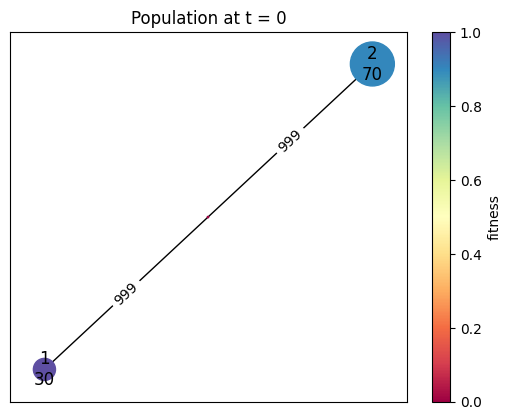

In [39]:
## DEPRECATED ##

def generate_initial_pop(fitnesses,abundances):
    ''' generate an initial population of len(fitnesses) strains with fitness and abundance values provided in lists'''
    
    fitnesses=np.insert(fitnesses,0, 0)
    abundances=np.insert(abundances,0, 0)

    G = nx.complete_bipartite_graph(1,len(fitnesses)-1) # create empty graph of n strains
    for i in range(len(G.nodes)): # for each strain, add fitness and abundance data
        G.add_node(i, abundance=abundances[i],fitness=fitnesses[i])
    for start,end in G.edges:
        G.add_edge(start,end,distance=999)  
        
    return(G)

################

fitnesses=[1,0.9] # allele_id:fitness
abundances=[30,70] # allele_id:abundance

G=generate_initial_pop(fitnesses,abundances)
visualize_pop(G)

/tmp/ipykernel_1421814/1642149511.py:47: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm,label='fitness')


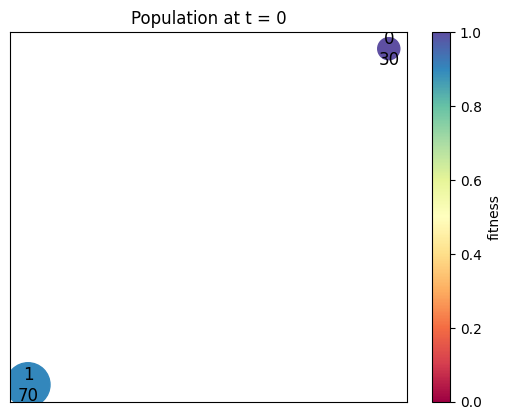

In [40]:
def generate_initial_pop_unlinked(fitnesses,abundances):
    ''' generate an initial population of len(fitnesses) strains with fitness and abundance values provided in lists'''
    
    G = nx.Graph()
    G.add_nodes_from([i, {'abundance':abundances[i],'fitness':fitnesses[i]}] for i in range(len(fitnesses)))
            
    return(G)

################

fitnesses=[1,0.9] # allele_id:fitness
abundances=[30,70] # allele_id:abundance

G=generate_initial_pop_unlinked(fitnesses,abundances)
visualize_pop(G)

In [41]:
## DEPRECATED ##

def generate_random_initial_pop(n):
    ''' generate a random initial population of n strains'''

    fitnesses=np.insert(np.random.rand(n), 0, 0) # # an array of n random numbers generated between 0 and 1
    abundances=np.insert(np.ceil(np.random.rand(n)*100).astype(int),0,0) # an array of n random numbers generated between 1 and 100

    # print(fitnesses)
    # print(abundances)

    G = nx.complete_bipartite_graph(1,n) # create empty graph of n strains
    for i in range(len(G.nodes)): # for each strain, add fitness and abundance data
        G.add_node(i, abundance=abundances[i],fitness=fitnesses[i])
    for start,end in G.edges:
        G.add_edge(start,end,distance=999)  
        
    return(G)


###########
# n=4 # number of strains
# G=generate_random_initial_pop(n)
# visualize_pop(G)


[0.44396205 0.70646184 0.69528472 0.18711797 0.94217882 0.76786783
 0.65667927 0.77089073 0.36262309 0.50411674 0.62332104 1.10023243
 0.53719486 0.99466038 0.82364712 1.05184552 1.17184099 0.99352491
 0.65192934 0.7444984  0.41793887 0.5793151  0.94430327 0.62482594
 0.49099301 0.59602872 1.05968665 0.97408101 0.42021261 0.99093985
 0.86177887 0.68724134 0.86375899 0.83888862 0.58409198 0.87816225
 0.53193282 0.73578517 0.36654063 0.9661969  0.42088494 1.22596884
 0.78377226 0.71094958 0.86511683 0.64349668 0.47593501 1.344175
 1.01647388 0.9392396  1.07978628 1.10943198 1.11117851 0.70303173
 0.79776917 0.71136379 0.8931533  1.02245185 0.90717443 0.67121436
 0.98231835 0.7532867  0.46158842 0.61892666 1.2440668  0.96193162
 1.04236518 0.47874123 0.85195186 0.92842499 0.89558521 0.92221168
 1.03794249 0.95518986 0.58018497 0.77732855 0.70874327 0.27555044
 0.61709881 0.74221598 1.17921645 0.60349822 0.90553042 0.96335614
 0.46925753 0.78480812 0.90123834 0.80922616 0.64375698 0.762547

/tmp/ipykernel_1421814/1642149511.py:47: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm,label='fitness')


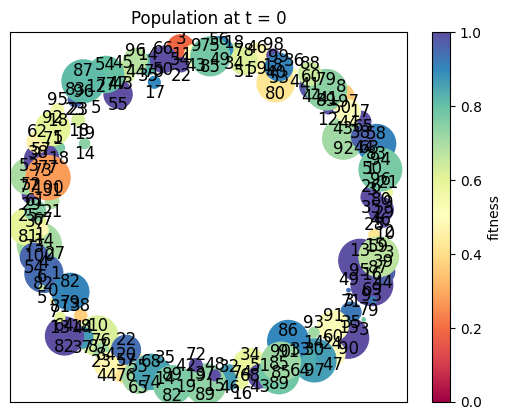

In [42]:

def generate_random_initial_pop_unlinked(n=100,i=20):
    ''' generate a random initial population of n individuals and i strains'''
    fitnesses=np.random.normal(loc=0.8, scale=0.2, size=n)
    # fitnesses=np.random.rand(n) # # an array of n random numbers generated between 0 and 1
    abundances=np.ceil(np.random.rand(n)*100).astype(int) # an array of n random numbers generated between 1 and 100
    print(fitnesses)
    G = nx.Graph()
    G.add_nodes_from([i, {'abundance':abundances[i],'fitness':fitnesses[i]}] for i in range(len(fitnesses)))
        
    return(G)


###########
n=100
i=4 # number of strains
G=generate_random_initial_pop_unlinked(n,i)
visualize_pop(G)

In [43]:
## DEPRECATED ##

def remove_empty_nodes_and_reconnect(G):
    ''' not good because ir works node by node. instead, I should try to extract these long branches first.'''
    nodes_to_remove = [node for node,attr in G.nodes(data=True) if attr['abundance']==0]
    newG=G.copy()
    
    for node in nodes_to_remove:
        old_edges=G.edges([node])
        new_edges=list(combinations([other_node for node, other_node in old_edges],2))
        new_edges_with_weights=[(edge[0],edge[1],{'distance':nx.shortest_path_length(G, source=edge[0], target=edge[1], weight='distance')}) for edge in new_edges]
        newG.add_edges_from(new_edges_with_weights)
        newG.remove_edges_from(old_edges)
    newG.remove_nodes_from(nodes_to_remove)
    
    return(newG)
    # return(nx.minimum_spanning_tree(newG))

########

# n=4 # number of strains

# fitnesses=[1,0.9] # allele_id:fitness
# abundances=[30,70] # allele_id:abundance


# G=generate_random_initial_pop(n)
# newG=remove_empty_nodes_and_reconnect(G)
# visualize_pop(newG)

In [44]:
## DEPRECATED ##

def remove_empty_leaves_and_rescale_edges_old(G):
   
    newG=G.copy()
    
    ## remove leaves
    
    nodes_to_remove = [node for node,attr in G.nodes(data=True) if attr['abundance']==0 and G.degree(node)<3]

    for node in nodes_to_remove:
        old_edges=G.edges([node])
        new_edges=list(combinations([other_node for node, other_node in old_edges],2))
        print(new_edges)
        new_edges_with_weights=[(edge[0],edge[1],{'distance':nx.shortest_path_length(G, source=edge[0], target=edge[1], weight='distance')}) for edge in new_edges]
        print(new_edges_with_weights)
        newG.add_edges_from(new_edges_with_weights)
        newG.remove_edges_from(old_edges)
    newG.remove_nodes_from(nodes_to_remove)
    
    return(newG)

########

# n=4
# fitnesses=np.insert(np.random.rand(n), 0, 0) # # an array of n random numbers generated between 0 and 1
# abundances=np.insert(np.ceil(np.random.rand(n)*100).astype(int),0,0) # an array of n random numbers generated between 
# G = nx.complete_bipartite_graph(1,n) # create empty graph of n strains
# for i in range(len(G.nodes)): # for each strain, add fitness and abundance data
#     G.add_node(i, abundance=abundances[i],fitness=fitnesses[i])
# for start,end in G.edges:
#     G.add_edge(start,end,distance=999)
# G.update(edges=[[2,n+1,{'distance':1}],[2,n+2,{'distance':1}],[n+2,n+3,{'distance':1}],[n+3,n+4,{'distance':1}],[n+4,n+5,{'distance':1}],[n+5,n+6,{'distance':1}],[n+6,n+7,{'distance':1}]], nodes=[[n+1,{'abundance':0,'fitness':1}],[n+2,{'abundance':0,'fitness':1}],[n+3,{'abundance':0,'fitness':1}],[n+4,{'abundance':10,'fitness':1}],[n+5,{'abundance':0,'fitness':1}],[n+6,{'abundance':0,'fitness':1}],[n+7,{'abundance':10,'fitness':1}]])

# visualize_pop(G,abundance_threshold=0)

# plt.figure()
# newG=remove_empty_leaves_and_rescale_edges_old(G)
# visualize_pop(newG)

/tmp/ipykernel_1421814/1642149511.py:47: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm,label='fitness')


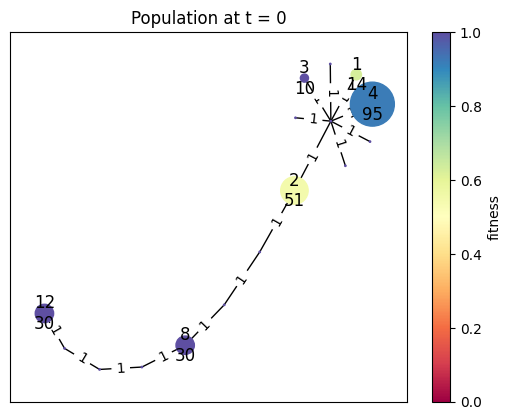

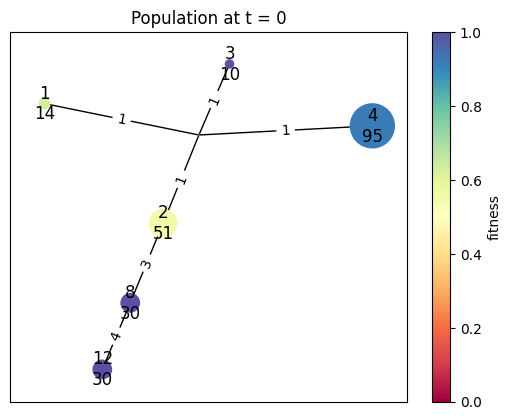

In [45]:

def remove_empty_leaves_and_rescale_edges(G):
   
    newG=G.copy()
    
    ## remove empty leaves
    
    nodes_to_remove = [node for node,attr in G.nodes(data=True) if attr['abundance']==0 and G.degree(node)<2]
    edges_to_remove = G.edges(nodes_to_remove)
    
    newG.remove_nodes_from(nodes_to_remove)
    newG.remove_edges_from(edges_to_remove)
    
    ## find and collapse chain of edges between empty nodes
    
    nodes_to_remove = [node for node,attr in newG.nodes(data=True) if attr['abundance']==0 and newG.degree(node)==2]
    edges_to_remove = []
    new_edges_with_weights =[]
    
    subgraphs=[newG.subgraph(c).copy() for c in nx.connected_components(newG.subgraph(nodes_to_remove))]

    for sg in subgraphs:
        old_edges=newG.edges(sg.nodes())
        edges_to_remove+=old_edges
        
        new_edge=[node for node in np.array(list(old_edges)).flatten() if node not in sg.nodes()]
        new_edges_with_weights+=[[new_edge[0],new_edge[1],{'distance':nx.shortest_path_length(newG, source=new_edge[0], target=new_edge[1], weight='distance')}]]

    newG.remove_nodes_from(nodes_to_remove)
    newG.remove_edges_from(edges_to_remove)
    newG.add_edges_from(new_edges_with_weights)
        
    
    return(newG)

########

n=4
fitnesses=np.insert(np.random.rand(n), 0, 0) # # an array of n random numbers generated between 0 and 1
abundances=np.insert(np.ceil(np.random.rand(n)*100).astype(int),0,0) # an array of n random numbers generated between 
G = nx.complete_bipartite_graph(1,n) # create empty graph of n strains
for i in range(len(G.nodes)): # for each strain, add fitness and abundance data
    G.add_node(i, abundance=abundances[i],fitness=fitnesses[i])
for start,end in G.edges:
    G.add_edge(start,end,distance=1)
G.update(edges=[[0,n+9,{'distance':1}],[0,n+10,{'distance':1}],[0,n+11,{'distance':1}],[0,n+1,{'distance':1}],[2,n+2,{'distance':1}],[n+2,n+3,{'distance':1}],[n+3,n+4,{'distance':1}],[n+4,n+5,{'distance':1}],[n+5,n+6,{'distance':1}],[n+6,n+7,{'distance':1}],[n+7,n+8,{'distance':1}]], 
         nodes=[[0,{'abundance':0,'fitness':1}],[3,{'abundance':10,'fitness':1}],[n+1,{'abundance':0,'fitness':1}],[n+2,{'abundance':0,'fitness':1}],[n+3,{'abundance':0,'fitness':1}],[n+4,{'abundance':30,'fitness':1}],[n+5,{'abundance':0,'fitness':1}],[n+6,{'abundance':0,'fitness':1}],[n+7,{'abundance':0,'fitness':1}],[n+8,{'abundance':30,'fitness':1}],[n+9,{'abundance':0,'fitness':1}],[n+10,{'abundance':0,'fitness':1}],[n+11,{'abundance':0,'fitness':1}]])

# G = nx.Graph()
# G.add_nodes_from([[1,{'abundance':5}],[2,{'abundance':10}],[3,{'abundance':0}],[4,{'abundance':0}],[5,{'abundance':0}],[6,{'abundance':0}],[7,{'abundance':5}],[8,{'abundance':10}]])
# G.add_edges_from([[1,2,{'distance':999}],[2,3,{'distance':1}],[2,4,{'distance':1}],[4,5,{'distance':1}],[5,6,{'distance':1}],[6,7,{'distance':1}],[6,8,{'distance':1}]])

plt.figure()
visualize_pop(G,i=0,abundance_threshold=1)
# nx.draw(G,with_labels=True)

H=remove_empty_leaves_and_rescale_edges(G)

plt.figure()
visualize_pop(H,i=0,abundance_threshold=1)
# nx.draw(H,with_labels=True)


# Toy example

## Example 1: Stable population (default)

In [6]:
np.random.seed(666)
mutation_rate=0.01

# fitnesses=[0.2,0.2,0.2,0.2,0.2] # allele_id:fitness
# abundances=[2,1,3,3,6] # allele_id:abundance
fitnesses=[0.95,0.9] # allele_id:fitness
abundances=[30,70] # allele_id:abundance

G=generate_initial_pop_unlinked(fitnesses,abundances)

# G=generate_random_initial_pop_unlinked(n=2000,i=10) #n=individuals, i=strains

runtime=2000
results=run_until_fixation(G,mutation_rate,runtime,stop_when_fixed=True,verbose=False)
print(len(results))

2002


False


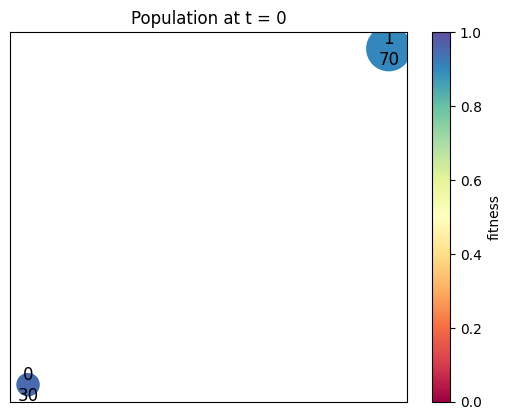

True


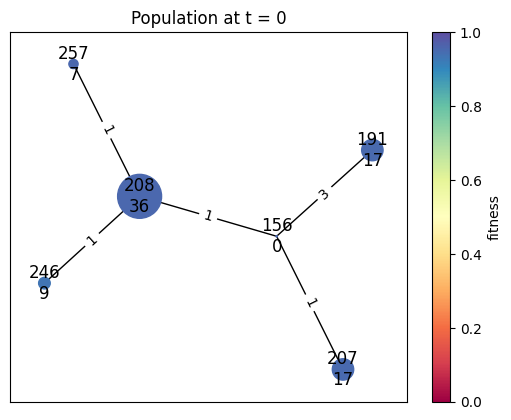

True


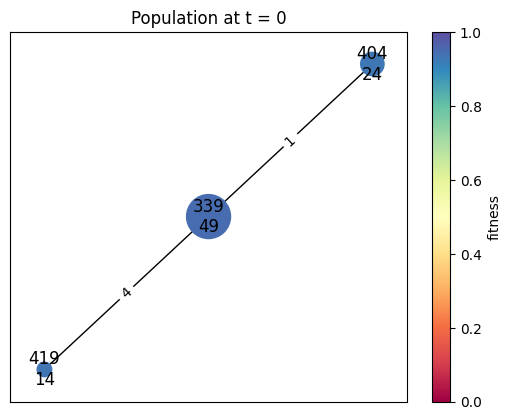

True


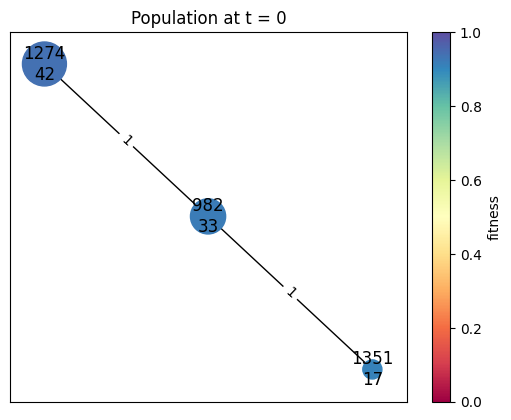

In [9]:
for i in [0,400,600,len(results)-1]:
    print(nx.is_tree(results[i]))
    plt.figure()
    # Generate plot1
    visualize_pop(results[i],view_node_labels=True,view_edge_labels=True,abundance_threshold='5%')
    # Show the plot in non-blocking mode
    plt.show(block=False)

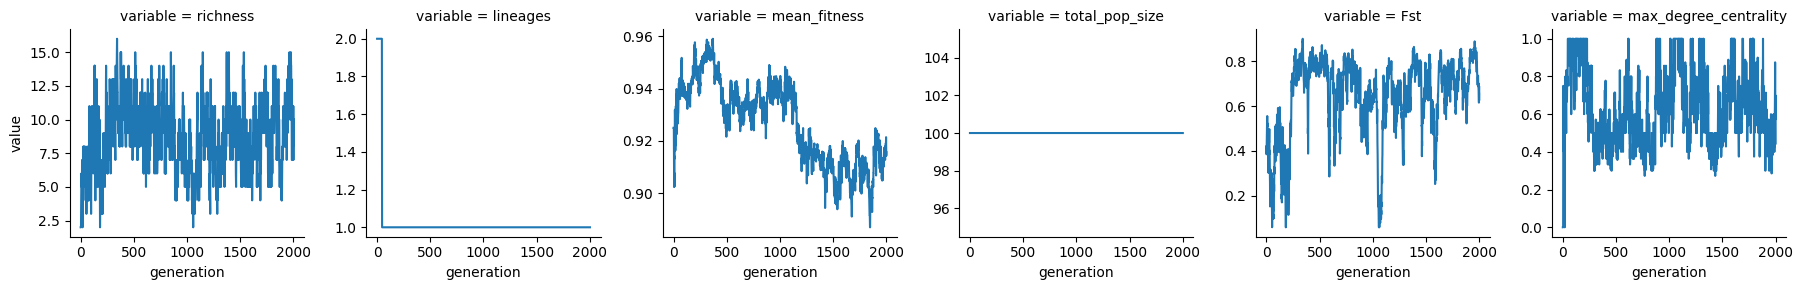

In [14]:
df_diversity=pd.DataFrame([])
for i in range(len(results)):
# for i in [0]:
    G=results[i]    
    richness=len(G.nodes)
    maxdist=sum([attr['distance'] for a,b,attr in nx.maximum_spanning_tree(G,weight='distance').edges(data=True)])
    mean_fitness=np.mean([attr['fitness'] for node,attr in G.nodes(data=True)])
    pop_size=sum([attr['abundance'] for node,attr in G.nodes(data=True)])
    gen_deg=nx.generalized_degree(G)
    lineages=nx.number_connected_components(G)
    max_degree_centrality=max([v for v in nx.degree_centrality(G).values()])
    Hi=1-sum([(attr['abundance']/pop_size)**2 for node,attr in G.nodes(data=True)])
    tmp=pd.DataFrame.from_dict({i:[richness,lineages,mean_fitness,pop_size,Hi,max_degree_centrality]}, orient='index',columns=['richness','lineages','mean_fitness','total_pop_size','Fst','max_degree_centrality'])
    tmp['generation']=i
    df_diversity=pd.concat([df_diversity, tmp], ignore_index=True)
df_diversity=df_diversity.melt(id_vars='generation')

g = sns.FacetGrid(df_diversity, col="variable",sharex=True, sharey=False)
g.map_dataframe(sns.lineplot, x="generation",y='value')


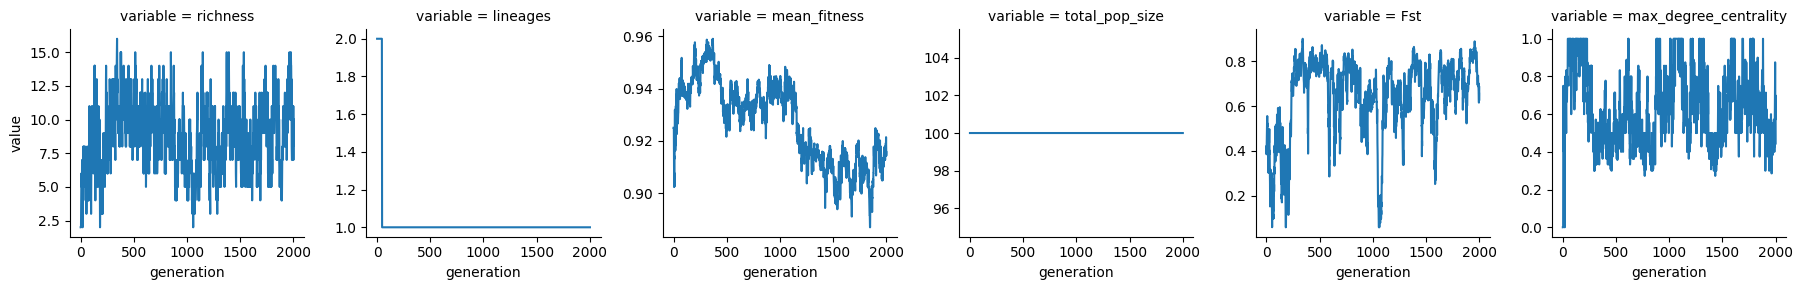

In [15]:
df_diversity=pd.DataFrame([])
for i in range(len(results)):
# for i in [0]:
    G=remove_empty_leaves_and_rescale_edges(results[i])  
    
    richness=len(G.nodes)
    maxdist=sum([attr['distance'] for a,b,attr in nx.maximum_spanning_tree(G,weight='distance').edges(data=True)])
    mean_fitness=np.mean([attr['fitness'] for node,attr in G.nodes(data=True)])
    pop_size=sum([attr['abundance'] for node,attr in G.nodes(data=True)])
    gen_deg=nx.generalized_degree(G)
    lineages=nx.number_connected_components(G)
    max_degree_centrality=max([v for v in nx.degree_centrality(G).values()])
    Hi=1-sum([(attr['abundance']/pop_size)**2 for node,attr in G.nodes(data=True)])
    tmp=pd.DataFrame.from_dict({i:[richness,lineages,mean_fitness,pop_size,Hi,max_degree_centrality]}, orient='index',columns=['richness','lineages','mean_fitness','total_pop_size','Fst','max_degree_centrality'])
    tmp['generation']=i
    df_diversity=pd.concat([df_diversity, tmp], ignore_index=True)
df_diversity=df_diversity.melt(id_vars='generation')

g = sns.FacetGrid(df_diversity, col="variable",sharex=True, sharey=False)
g.map_dataframe(sns.lineplot, x="generation",y='value')


In [17]:
import seaborn as sns

df_abundance=pd.DataFrame([])
for i in range(len(results)):    
    G=remove_empty_leaves_and_rescale_edges(results[i])
    tmp=pd.DataFrame.from_dict({node:attr['abundance'] for node, attr in G.nodes(data=True)}, orient='index',columns=['abundance'])
    tmp['node']=tmp.index
    tmp['generation']=i
    tmp['n']=tmp.abundance.sum()
    df_abundance=pd.concat([df_abundance, tmp], ignore_index=True)
df_abundance['relab']=df_abundance.abundance/df_abundance.n
# df_abundance

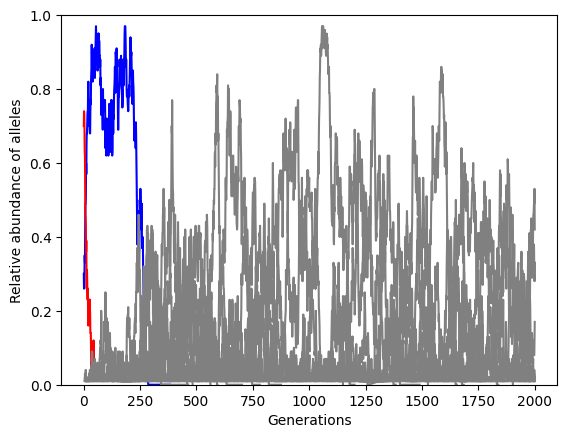

In [18]:
# print(df_abundance[:4])
my_colors={'0':'blue','1':'red'}
my_palette=dict([[k,my_colors[k]] if k in my_colors.keys() else [k,'grey'] for k in set(map(str,df_abundance.node))]) # all other alleles are colored "grey"

ax=sns.lineplot(data=df_abundance,x='generation',y=df_abundance.abundance/df_abundance.n,hue=map(str,df_abundance.node), palette=my_palette)
ax.set_ylim(0, 1)
ax.set(xlabel='Generations', ylabel='Relative abundance of alleles')
ax.get_legend().remove()

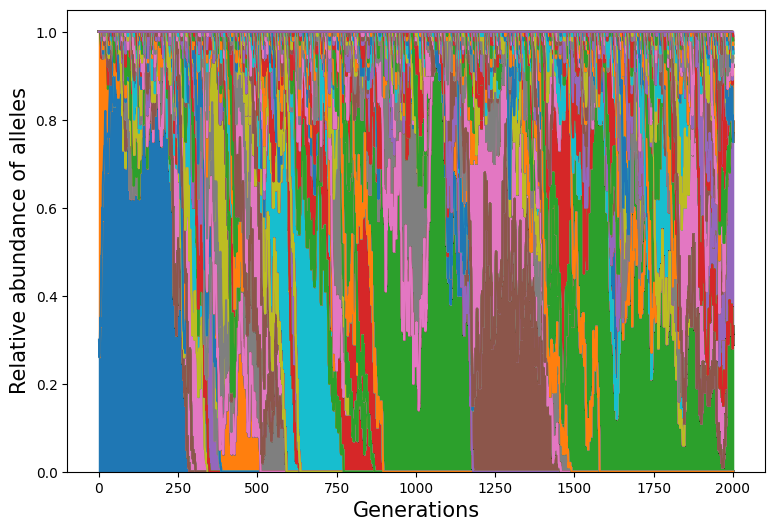

In [19]:
my_colors={'0':'blue','1':'red'}
my_palette=dict([[k,my_colors[k]] if k in my_colors.keys() else [k,'grey'] for k in set(map(str,df_abundance.node))]) # all other alleles are colored "grey"

# now pivot df
piv = df_abundance.pivot(index='generation', columns='node', values='relab')

# plot
ax = piv.plot(kind='area', figsize=(9, 6))
ax.set_xlabel('Generations', fontsize=15)
ax.set_ylabel('Relative abundance of alleles', fontsize=15)

# move the legend
ax.get_legend().remove()


## Example 2: Growing population 1

In [21]:
np.random.seed(666)
mutation_rate=0.0001
growth_factor=1.05
fitnesses=[0.95,0.9] # allele_id:fitness
abundances=[30,70] # allele_id:abundance

G=generate_initial_pop_unlinked(fitnesses,abundances)

runtime=200
results=run_until_fixation(G,mutation_rate,runtime,stop_when_fixed=True,verbose=50, growth_factor=growth_factor)
print(len(results))

50
100
150
200
202


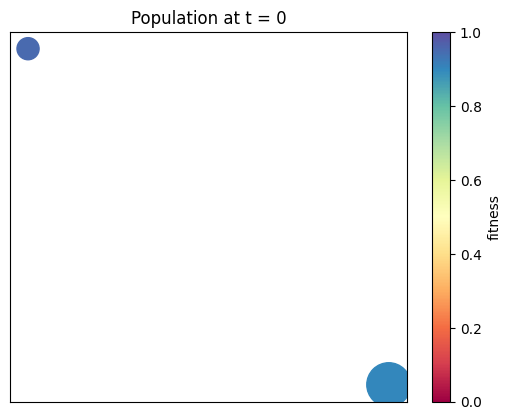

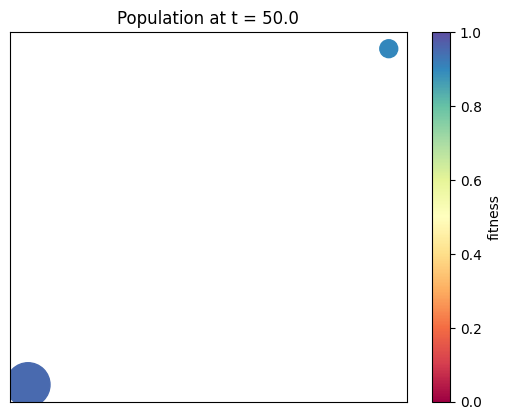

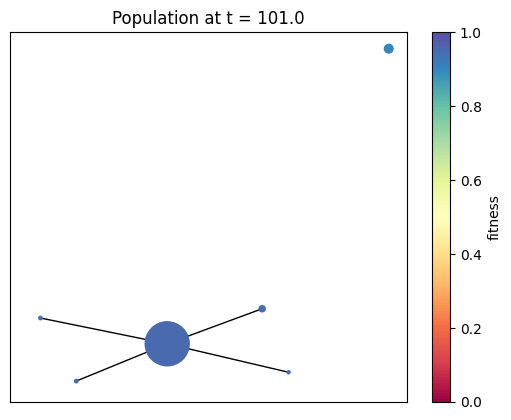

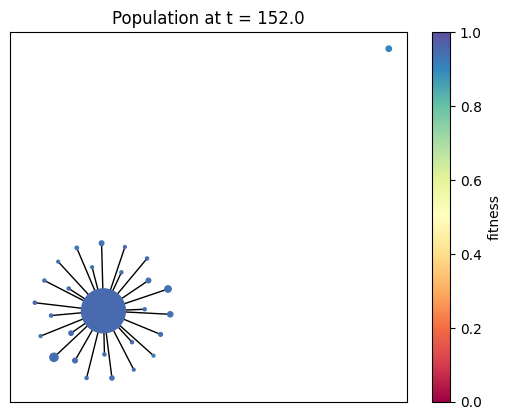

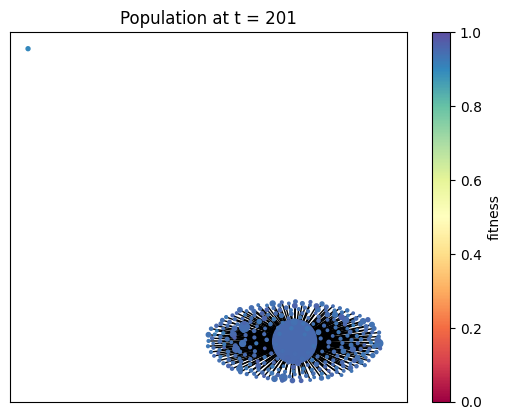

In [22]:
for i in [0,np.round(len(results)/4),np.round(len(results)/2),np.round(3*len(results)/4),len(results)-1]:
    plt.figure()
    # Generate plot1
    # print(results[i].nodes(data=True))
    visualize_pop(results[i],i,view_edge_labels=False,view_node_labels=False,abundance_threshold=5)
    # Show the plot in non-blocking mode
    plt.show(block=False)

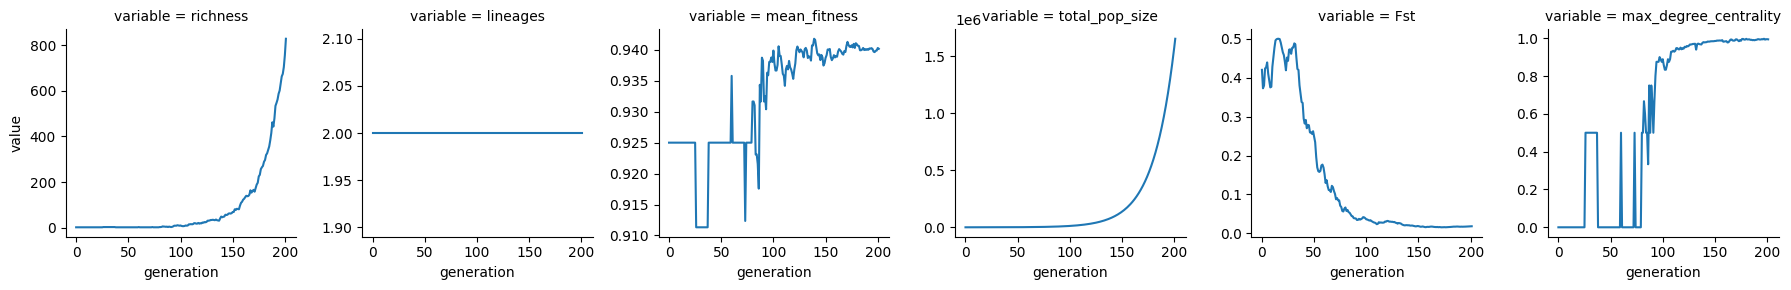

In [23]:
df_diversity=pd.DataFrame([])
for i in range(len(results)):
# for i in [0]:
    G=results[i]    
    richness=len(G.nodes)
    maxdist=sum([attr['distance'] for a,b,attr in nx.maximum_spanning_tree(G,weight='distance').edges(data=True)])
    mean_fitness=np.mean([attr['fitness'] for node,attr in G.nodes(data=True)])
    pop_size=sum([attr['abundance'] for node,attr in G.nodes(data=True)])
    gen_deg=nx.generalized_degree(G)
    lineages=nx.number_connected_components(G)
    max_degree_centrality=max([v for v in nx.degree_centrality(G).values()])
    Hi=1-sum([(attr['abundance']/pop_size)**2 for node,attr in G.nodes(data=True)])
    tmp=pd.DataFrame.from_dict({i:[richness,lineages,mean_fitness,pop_size,Hi,max_degree_centrality]}, orient='index',columns=['richness','lineages','mean_fitness','total_pop_size','Fst','max_degree_centrality'])
    tmp['generation']=i
    df_diversity=pd.concat([df_diversity, tmp], ignore_index=True)
df_diversity=df_diversity.melt(id_vars='generation')

g = sns.FacetGrid(df_diversity, col="variable",sharex=True, sharey=False)
g.map_dataframe(sns.lineplot, x="generation",y='value')


## Example 3: Growing population 2 high mutation_rate

In [24]:
np.random.seed(666)
mutation_rate=0.005
growth_factor=1.05
fitnesses=[0.95,0.9] # allele_id:fitness
abundances=[30,70] # allele_id:abundance

G=generate_initial_pop_unlinked(fitnesses,abundances)

runtime=150
results=run_until_fixation(G,mutation_rate,runtime,stop_when_fixed=True,verbose=50, growth_factor=growth_factor)
print(len(results))

50
100
150
152


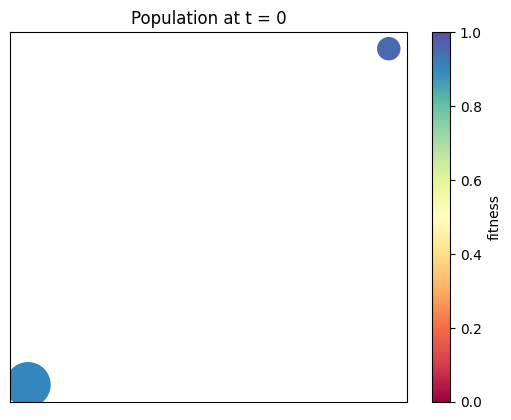

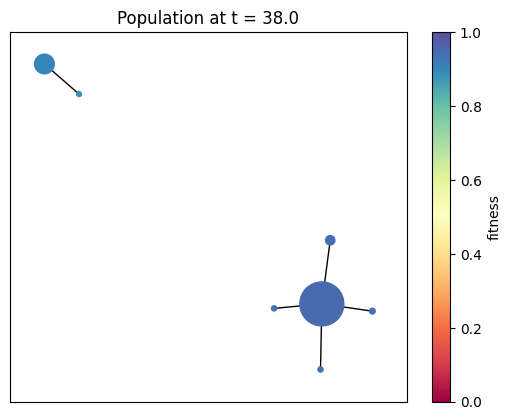

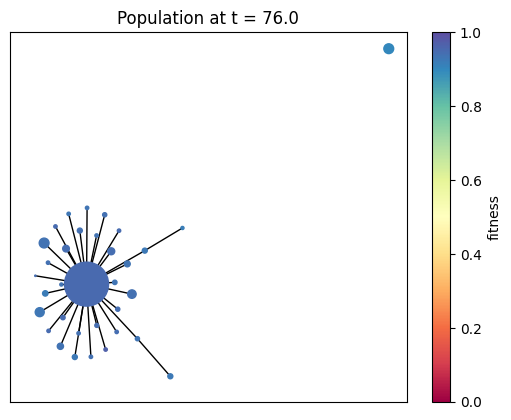

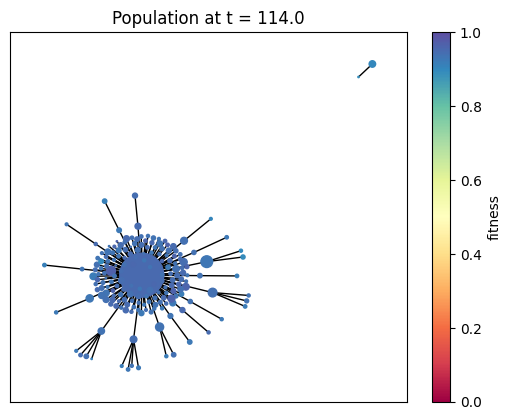

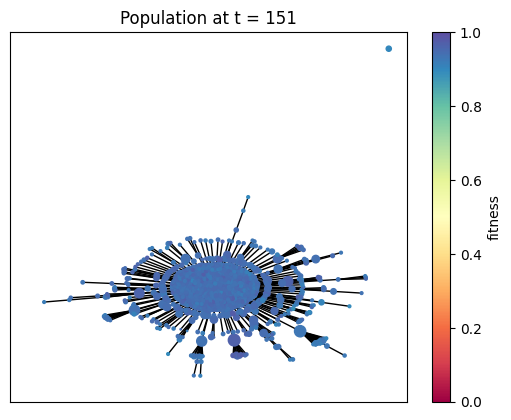

In [27]:
for i in [0,np.round(len(results)/4),np.round(len(results)/2),np.round(3*len(results)/4),len(results)-1]:
    plt.figure()
    visualize_pop(results[i],i,view_edge_labels=False,view_node_labels=False,abundance_threshold=5)
    plt.show(block=False)

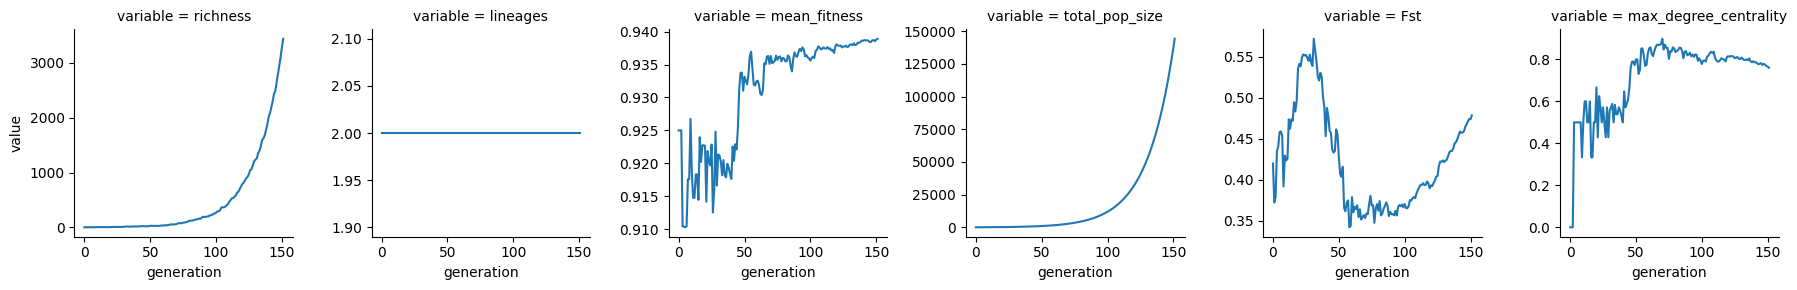

In [28]:
df_diversity=pd.DataFrame([])
for i in range(len(results)):
# for i in [0]:
    G=results[i]    
    richness=len(G.nodes)
    maxdist=sum([attr['distance'] for a,b,attr in nx.maximum_spanning_tree(G,weight='distance').edges(data=True)])
    mean_fitness=np.mean([attr['fitness'] for node,attr in G.nodes(data=True)])
    pop_size=sum([attr['abundance'] for node,attr in G.nodes(data=True)])
    gen_deg=nx.generalized_degree(G)
    lineages=nx.number_connected_components(G)
    max_degree_centrality=max([v for v in nx.degree_centrality(G).values()])
    Hi=1-sum([(attr['abundance']/pop_size)**2 for node,attr in G.nodes(data=True)])
    tmp=pd.DataFrame.from_dict({i:[richness,lineages,mean_fitness,pop_size,Hi,max_degree_centrality]}, orient='index',columns=['richness','lineages','mean_fitness','total_pop_size','Fst','max_degree_centrality'])
    tmp['generation']=i
    df_diversity=pd.concat([df_diversity, tmp], ignore_index=True)
df_diversity=df_diversity.melt(id_vars='generation')

g = sns.FacetGrid(df_diversity, col="variable",sharex=True, sharey=False)
g.map_dataframe(sns.lineplot, x="generation",y='value')


# Realistic example

In [179]:
def generate_random_fisherlog_pop_unlinked(i=10):
    ''' generate a random initial population of i strains'''
    a = .995 # adjusted to match Ridgeia symbs CRISPR alleles/reads
    s = np.random.logseries(a, i)
    abundances=[k for k, v in Counter(s).items() for _ in range(v)] # species_count: individual_counts in these species
    fitnesses=np.random.normal(loc=0.8, scale=0.2, size=n) #average fitness 0.8, std 0.2
    G = nx.Graph()
    G.add_nodes_from([i, {'abundance':abundances[i],'fitness':fitnesses[i]}] for i in range(len(fitnesses)))
        
    return(G)

generate_random_fisherlog_pop_unlinked(i=10)

/home/maeperez/virtualenv/py311/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


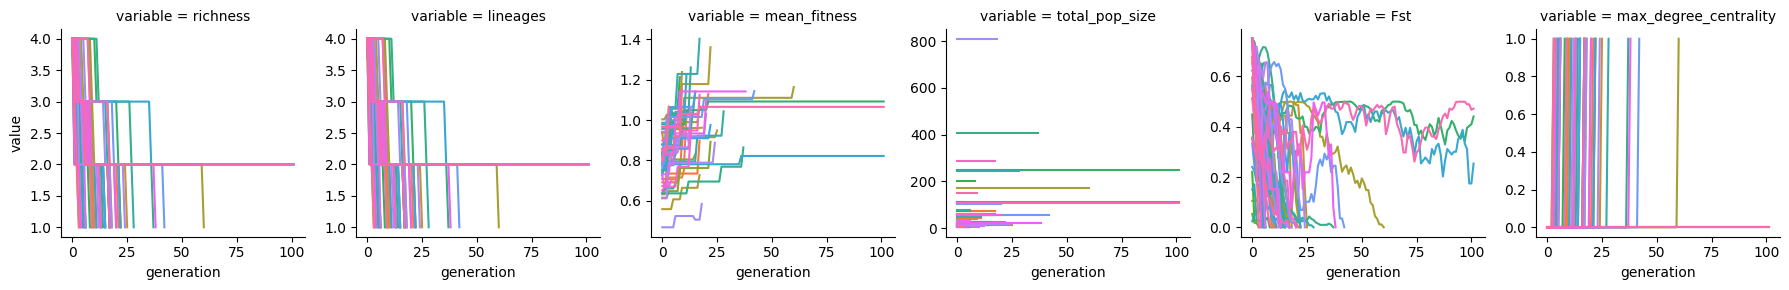

In [181]:
# np.random.seed(666)
mutation_rate=0.00000001

df_diversity=pd.DataFrame([])

for iteration in range(50):
    
    G=generate_random_fisherlog_pop_unlinked(i=200) #n=individuals, i=strains
    runtime=100
    results=run_until_fixation(G,mutation_rate,runtime,stop_when_fixed=True,verbose=False)
    
    ###########
    
    for i in range(len(results)):
        G=results[i]

        richness=len(G.nodes)
        maxdist=sum([attr['distance'] for a,b,attr in nx.maximum_spanning_tree(G,weight='distance').edges(data=True)])
        mean_fitness=np.mean([attr['fitness'] for node,attr in G.nodes(data=True)])
        pop_size=sum([attr['abundance'] for node,attr in G.nodes(data=True)])
        gen_deg=nx.generalized_degree(G)
        lineages=nx.number_connected_components(G)
        max_degree_centrality=max([v for v in nx.degree_centrality(G).values()])
        Hi=1-sum([(attr['abundance']/pop_size)**2 for node,attr in G.nodes(data=True)])
        tmp=pd.DataFrame.from_dict({i:[richness,lineages,mean_fitness,pop_size,Hi,max_degree_centrality]}, orient='index',columns=['richness','lineages','mean_fitness','total_pop_size','Fst','max_degree_centrality'])
        tmp['generation']=i
        tmp['iteration']=iteration
        df_diversity=pd.concat([df_diversity, tmp], ignore_index=True)


df_diversity=df_diversity.melt(id_vars=['iteration','generation'])

g = sns.FacetGrid(df_diversity, col="variable",sharex=True, sharey=False,hue='iteration')
g.map_dataframe(sns.lineplot, x="generation",y='value')

/home/maeperez/virtualenv/py311/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


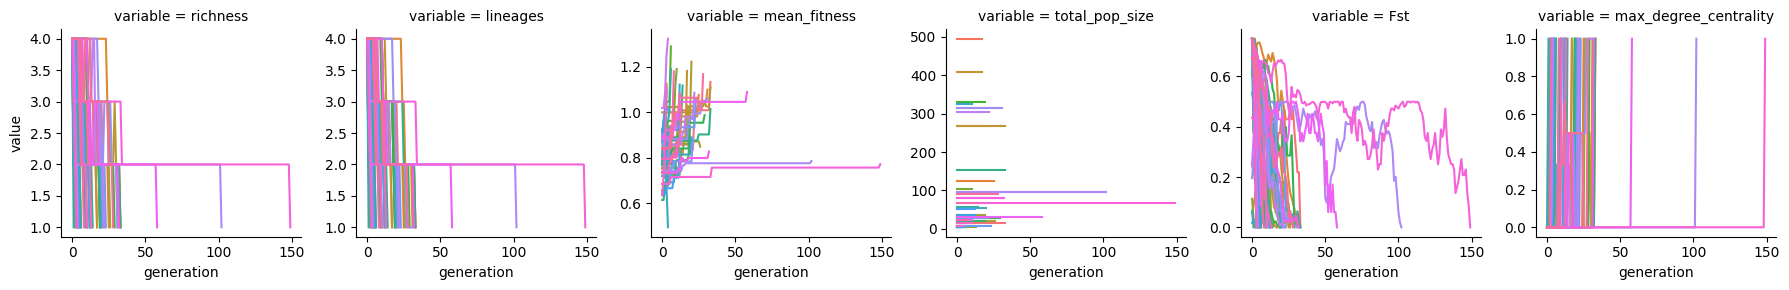

In [183]:
# np.random.seed(666)
mutation_rate=0.0001

df_diversity=pd.DataFrame([])

for iteration in range(50):
    
    G=generate_random_fisherlog_pop_unlinked(i=200) #n=individuals, i=strains
    runtime=1000
    results=run_until_fixation(G,mutation_rate,runtime,stop_when_fixed=True,verbose=False)
    
    ###########
    
    for i in range(len(results)):
        G=results[i]

        richness=len(G.nodes)
        maxdist=sum([attr['distance'] for a,b,attr in nx.maximum_spanning_tree(G,weight='distance').edges(data=True)])
        mean_fitness=np.mean([attr['fitness'] for node,attr in G.nodes(data=True)])
        pop_size=sum([attr['abundance'] for node,attr in G.nodes(data=True)])
        gen_deg=nx.generalized_degree(G)
        lineages=nx.number_connected_components(G)
        max_degree_centrality=max([v for v in nx.degree_centrality(G).values()])
        Hi=1-sum([(attr['abundance']/pop_size)**2 for node,attr in G.nodes(data=True)])
        tmp=pd.DataFrame.from_dict({i:[richness,lineages,mean_fitness,pop_size,Hi,max_degree_centrality]}, orient='index',columns=['richness','lineages','mean_fitness','total_pop_size','Fst','max_degree_centrality'])
        tmp['generation']=i
        tmp['iteration']=iteration
        df_diversity=pd.concat([df_diversity, tmp], ignore_index=True)


df_diversity=df_diversity.melt(id_vars=['iteration','generation'])

g = sns.FacetGrid(df_diversity, col="variable",sharex=True, sharey=False,hue='iteration')
g.map_dataframe(sns.lineplot, x="generation",y='value')

In [2]:
import numpy as np

# Set the seed for reproducibility
np.random.seed(0)

# Define the colors and their associated probabilities
colors = ['blue', 'red', 'green']
probabilities = [0.2, 0.3, 0.5]

# Determine the count of each color in 100 draws
counts = np.random.multinomial(100, probabilities)
print(counts)
color_counts = dict(zip(colors, counts))

print(color_counts)

[20 32 48]
{'blue': 20, 'red': 32, 'green': 48}


In [12]:
a=[2,2,2]
b=[5,5,5]
c=5
np.array(a)*5
np.array(a)*0.00001

array([2.e-05, 2.e-05, 2.e-05])

In [43]:
a={1:10,2:10}
b={1:3,2:3}
# a.update(a-b)

# np.array(a.values())/2
[val/2 for val in a.values()]

[5.0, 5.0]